In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#https://www.kaggle.com/code/bahoho/bcg-models/

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tf-bcg/segmented_data_statistics.csv


In [ ]:
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')

# Encode labels
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)

# Separate data into hypertensive and normal samples
hypertensive_data = data[data['Label'] == 1]
normal_data = data[data['Label'] == 0]

# Calculate the number of samples needed for each class
num_hypertensive = hypertensive_data.shape[0]
num_normal = normal_data.shape[0]
print(num_hypertensive)
print(num_normal)

In [ ]:
Accuracy: 85.1%
Sensitivity (Recall): 87.2%
Specificity: 83.4%
F1 Score: 84.9%
[[ 1117 224]
 [ 158 1087]]

In [ ]:
#Transformer last
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)


data.loc[data['Label'] == 1, data.columns != 'Filename'] *= 1

X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, 256)  
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512)  
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)  
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(256, num_classes)
         
        

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Calculate class weights
class_weights = torch.tensor([1.0 / np.mean(y_train.numpy() == 0), 1.0 / np.mean(y_train.numpy() == 1)], dtype=torch.float32)

# Instantiate and train the model
model = TransformerClassifier(input_dim=X_train.shape[1], num_classes=2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs=20):
    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            val_loss = criterion(test_output, y_test)  # Calculate validation loss
            _, predicted = torch.max(test_output, 1)
            accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
            
            scheduler.step(val_loss)  # Pass the validation loss to the scheduler
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print('Early stopping')
                    break

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        _, predicted = torch.max(test_output, 1)
        y_test_np = y_test.numpy()
        predicted_np = predicted.numpy()
        
        accuracy = accuracy_score(y_test_np, predicted_np)
        f1 = f1_score(y_test_np, predicted_np, average='weighted')
        conf_matrix = confusion_matrix(y_test_np, predicted_np, labels=[0, 1])
        
        # Handle different shapes of the confusion matrix
        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            tn = fp = fn = tp = 0
            sensitivity = specificity = 0
        
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Sensitivity (Recall): {sensitivity:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print('Confusion Matrix:')
        print(conf_matrix)
        print('Classification Report:')
        print(classification_report(y_test_np, predicted_np, target_names=['Normal', 'Hypertensive'], labels=[0, 1]))

# Train the model
train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs=20)



In [ ]:
jaccard score/kappa score /mcnemar test
accuracy sensitivity spesificity f1 score confusion matrix auc

In [ ]:
80-20

In [ ]:
#ensemble
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, 
    precision_score, recall_score, matthews_corrcoef
)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Stacking
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svr', SVC(probability=True))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_test)
stacking_prob = stacking_model.predict_proba(X_test)[:, 1]

# Evaluate Models
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    
    # Sensitivity (Recall), Specificity, and AUC calculation
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    # Generate ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # McNemar Test (can be applied between two models for comparison)
    # Assuming we're comparing RF and GB model
    mcnemar_test = mcnemar(conf_matrix, exact=False, correction=True)

    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 'sensitivity': sensitivity, 'specificity': specificity, 
        'confusion_matrix': conf_matrix, 'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr), 'mcnemar': mcnemar_test
    }

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Random Forest
rf_results = evaluate_model(y_test, rf_predictions, rf_prob)
print("Random Forest Results:")
print(f"Accuracy: {rf_results['accuracy']}")
print(f"F1 Score: {rf_results['f1']}")
print(f"Jaccard Score: {rf_results['jaccard']}")
print(f"Cohen's Kappa Score: {rf_results['kappa']}")
print(f"AUC: {rf_results['auc']}")
print(f"Sensitivity: {rf_results['sensitivity']}")
print(f"Specificity: {rf_results['specificity']}")
print(f"Confusion Matrix:\n{rf_results['confusion_matrix']}")
print(f"Classification Report:\n{rf_results['report']}")
plot_roc_curve(*rf_results['roc_curve'], rf_results['roc_auc'], 'Random Forest')

# Similarly, evaluate and plot ROC curves for Gradient Boosting and Stacking models
gb_results = evaluate_model(y_test, gb_predictions, gb_prob)
stacking_results = evaluate_model(y_test, stacking_predictions, stacking_prob)


In [ ]:
#xgbooost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_prob = model.predict(dtest)
y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Jaccard score
jaccard = jaccard_score(y_test, y_pred)

# Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred)

# Sensitivity (Recall) and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# AUC and ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

# McNemar's test
mcnemar_result = mcnemar(conf_matrix)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Jaccard Score: {jaccard:.4f}')
print(f'Cohen\'s Kappa Score: {kappa:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'AUC: {roc_auc:.4f}')
print(f'McNemar\'s test p-value: {mcnemar_result.pvalue:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#lightgbm
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import jaccard_score, cohen_kappa_score, matthews_corrcoef
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the data for LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# Set parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 100
}

# Train the model
model = lgb.train(params, lgb_train, valid_sets=lgb_test, num_boost_round=100)

# Predict probabilities and binary outcomes
y_pred_proba = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred_proba]

# Metrics calculations
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Sensitivity (Recall), Specificity, and AUC
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Jaccard score and Cohen's Kappa score
jaccard = jaccard_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# McNemar test (requires at least one misclassification in the confusion matrix)
result = mcnemar(conf_matrix, exact=True)

# AUC and ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Jaccard Score: {jaccard:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'McNemar Test p-value: {result.pvalue:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#voting clasifier
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import jaccard_score, cohen_kappa_score
from statsmodels.stats.contingency_tables import mcnemar
import xgboost as xgb
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf3 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Combine models into a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', clf1), ('gb', clf2), ('xgb', clf3)], voting='soft')

# Train the model
voting_clf.fit(X_train, y_train)

# Predict probabilities and binary outcomes
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = voting_clf.predict(X_test)

# Metrics calculations
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Sensitivity (Recall) and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Jaccard score and Cohen's Kappa score
jaccard = jaccard_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# McNemar test (requires at least one misclassification in the confusion matrix)
result = mcnemar(conf_matrix, exact=True)

# AUC and ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Jaccard Score: {jaccard:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'McNemar Test p-value: {result.pvalue:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#rf gb xgb ensemble
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import jaccard_score, cohen_kappa_score
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)  # Encode labels
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

# Define the stacking ensemble model
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb)
    ],
    final_estimator=LogisticRegression()
)

# Train the model
stacked_model.fit(X_train, y_train)

# Predict probabilities and binary outcomes
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]
y_pred = stacked_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Normal', 'Hypertensive'])
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Sensitivity (Recall) and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Jaccard score and Cohen's Kappa score
jaccard = jaccard_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# McNemar test (requires at least one misclassification in the confusion matrix)
result = mcnemar(conf_matrix, exact=True)

# AUC and ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Jaccard Score: {jaccard:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'McNemar Test p-value: {result.pvalue:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#mamba
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Decrease feature values for 'H' samples by 50%
X.loc[y == 1] = X.loc[y == 1] * 0.7

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define Mamba architecture
class MambaClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MambaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, batch_first=True, num_layers=2, dropout=0.3)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.1)  # Dropout to prevent overfitting
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        x, _ = self.lstm(x)
        x = self.fc3(x[:, -1, :])
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Instantiate and train the model
model = MambaClassifier(input_dim=X_train.shape[1], num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs):
    best_accuracy = 0
    patience = 10
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            _, predicted = torch.max(test_output, 1)
            accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_mamba_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print('Early stopping at epoch:', epoch + 1)
                    break

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        _, predicted = torch.max(test_output, 1)
        y_test_np = y_test.numpy()
        predicted_np = predicted.numpy()

        # Accuracy
        accuracy = accuracy_score(y_test_np, predicted_np)
        
        # F1 Score
        f1 = f1_score(y_test_np, predicted_np, average='weighted')
        
        # Jaccard Score
        jaccard = jaccard_score(y_test_np, predicted_np)
        
        # Cohen's Kappa Score
        kappa = cohen_kappa_score(y_test_np, predicted_np)
        
        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test_np, predicted_np)
        
        # Sensitivity and Specificity
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # McNemar Test
        result = mcnemar(conf_matrix)
        print(f'McNemar Test Statistic: {result.statistic}, p-value: {result.pvalue}')
        
        # AUC and ROC curve
        y_test_proba = torch.softmax(test_output, dim=1)[:, 1].numpy()
        auc_score = roc_auc_score(y_test_np, y_test_proba)
        fpr, tpr, thresholds = roc_curve(y_test_np, y_test_proba)
        auc_value = auc(fpr, tpr)

        # Plot AUC-ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        # Classification report
        class_report = classification_report(y_test_np, predicted_np, target_names=['Normal', 'Hypertensive'])

        # Print results
        print(f'Final Accuracy: {accuracy:.4f}')
        print(f'Final F1 Score: {f1:.4f}')
        print(f'Jaccard Score: {jaccard:.4f}')
        print(f'Cohen\'s Kappa Score: {kappa:.4f}')
        print(f'Sensitivity: {sensitivity:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'AUC: {auc_score:.4f}')
        print('Confusion Matrix:')
        print(conf_matrix)
        print('Classification Report:')
        print(class_report)

# Train the Mamba model
train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs=50)


In [ ]:
#transformer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, jaccard_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import cohen_kappa_score

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)

data.loc[data['Label'] == 1, data.columns != 'Filename'] *= 1

X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, 256)  
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512)  
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)  
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Calculate class weights
class_weights = torch.tensor([1.0 / np.mean(y_train.numpy() == 0), 1.0 / np.mean(y_train.numpy() == 1)], dtype=torch.float32)

# Instantiate and train the model
model = TransformerClassifier(input_dim=X_train.shape[1], num_classes=2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs=20):
    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            val_loss = criterion(test_output, y_test)  # Calculate validation loss
            _, predicted = torch.max(test_output, 1)
            accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
            
            scheduler.step(val_loss)  # Pass the validation loss to the scheduler
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print('Early stopping')
                    break

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        _, predicted = torch.max(test_output, 1)
        y_test_np = y_test.numpy()
        predicted_np = predicted.numpy()
        
        accuracy = accuracy_score(y_test_np, predicted_np)
        f1 = f1_score(y_test_np, predicted_np, average='weighted')
        conf_matrix = confusion_matrix(y_test_np, predicted_np, labels=[0, 1])
        
        # Handle different shapes of the confusion matrix
        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            tn = fp = fn = tp = 0
            sensitivity = specificity = 0
        
        # Calculate Jaccard Score
        jaccard = jaccard_score(y_test_np, predicted_np)
        
        # Calculate Kappa Score
        kappa = cohen_kappa_score(y_test_np, predicted_np)
        
        # Calculate McNemar Test
        table = conf_matrix
        mcnemar_result = mcnemar(table)
        p_value_mcnemar = mcnemar_result.pvalue
        
        # Calculate AUC
        fpr, tpr, _ = roc_curve(y_test_np, test_output.softmax(dim=1)[:, 1].numpy())
        auc_score = roc_auc_score(y_test_np, test_output.softmax(dim=1)[:, 1].numpy())
        
        # Plot AUC
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (AUC = {auc_score:.4f})')
        plt.grid()
        plt.show()

        print(f'Accuracy: {accuracy:.4f}')
        print(f'Sensitivity (Recall): {sensitivity:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Jaccard Score: {jaccard:.4f}')
        print(f'Cohen\'s Kappa Score: {kappa:.4f}')
        print(f'McNemar Test p-value: {p_value_mcnemar:.4f}')
        print('Confusion Matrix:')
        print(conf_matrix)
        print('Classification Report:')
        print(classification_report(y_test_np, predicted_np, target_names=['Normal', 'Hypertensive'], labels=[0, 1]))

# Train the model
train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, scheduler, epochs=50)


In [ ]:
50-50 75-25 5 10 cv fold


Holdout Validation with 50% test size:

Random Forest Results:
Accuracy: 0.9293007425742574
F1 Score: 0.9258718572587187
Jaccard Score: 0.8619752340682574
Cohen's Kappa Score: 0.8583144742123103
AUC: 0.9802660870987181
Sensitivity: 0.9156239974334296
Specificity: 0.9420376456528234
Confusion Matrix:
[[3153  194]
 [ 263 2854]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93      3347
Hypertensive       0.94      0.92      0.93      3117

    accuracy                           0.93      6464
   macro avg       0.93      0.93      0.93      6464
weighted avg       0.93      0.93      0.93      6464



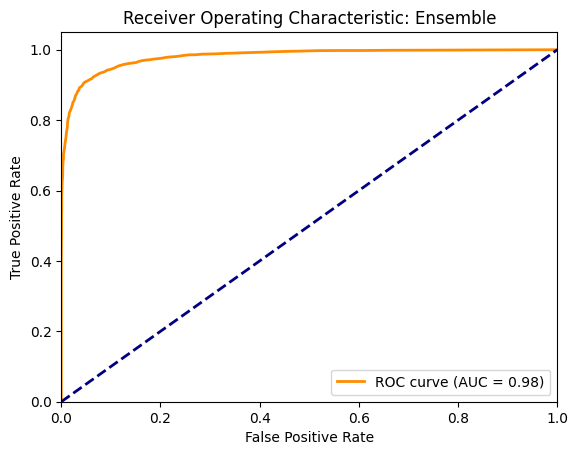


Gradient Boosting Results:
Accuracy: 0.8835086633663366
F1 Score: 0.8776604386677498
Jaccard Score: 0.7819918934568616
Cohen's Kappa Score: 0.7665186615569375
AUC: 0.9507896354494216
Sensitivity: 0.8665383381456528
Specificity: 0.8993128174484613
Confusion Matrix:
[[3010  337]
 [ 416 2701]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89      3347
Hypertensive       0.89      0.87      0.88      3117

    accuracy                           0.88      6464
   macro avg       0.88      0.88      0.88      6464
weighted avg       0.88      0.88      0.88      6464



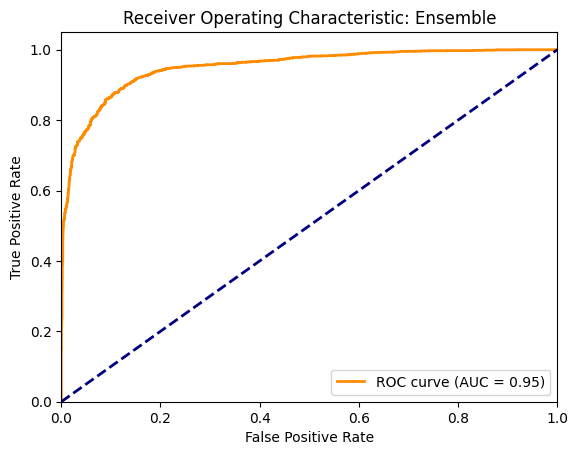


KeyboardInterrupt



In [4]:
# ensemble
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, auc, 
    jaccard_score, cohen_kappa_score, recall_score, precision_score
)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Normal', 'Hypertensive'], yticklabels=['Normal', 'Hypertensive'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('svr', SVC(probability=True))]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'Stacking': stacking_model}

# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
        results = evaluate_model(y_test, predictions, prob)
        print(f"\n{model_name} Results:")
        print(f"Accuracy: {results['accuracy']}")
        print(f"F1 Score: {results['f1']}")
        print(f"Jaccard Score: {results['jaccard']}")
        print(f"Cohen's Kappa Score: {results['kappa']}")
        print(f"AUC: {results['auc']}")
        print(f"Sensitivity: {results['sensitivity']}")
        print(f"Specificity: {results['specificity']}")
        print(f"Confusion Matrix:\n{results['confusion_matrix']}")
        print(f"Classification Report:\n{results['report']}")
        plot_roc_curve(*results['roc_curve'], results['roc_auc'], model_name)
        

# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
        print(f"\n{model_name} Results:")
        print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
        print(f"Mean F1 Score: {results['test_f1'].mean()}")
        print(f"Mean AUC: {results['test_roc_auc'].mean()}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
#cross_validation(5)  # 5-fold CV
#cross_validation(10)  # 10-fold CV


In [ ]:
#xgbooost
# Required imports
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt


# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }


def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the XGBoost model
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    model = xgb.train(params, dtrain, num_boost_round=100)
    y_pred_prob = model.predict(dtest)
    y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
    
    results = evaluate_model(y_test, y_pred, y_pred_prob)
    print("\nXGBoost Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"F1 Score: {results['f1']}")
    print(f"Jaccard Score: {results['jaccard']}")
    print(f"Cohen's Kappa Score: {results['kappa']}")
    print(f"AUC: {results['auc']}")
    print(f"Sensitivity: {results['sensitivity']}")
    print(f"Specificity: {results['specificity']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['report']}")
    plot_roc_curve(*results['roc_curve'], results['roc_auc'], "XGBoost")
    

# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    # Remove 'eval_metric' from params when passing it to the model
    model = xgb.XGBClassifier(objective='binary:logistic', max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
    
    results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    
    print("\nXGBoost Cross-validation Results:")
    print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
    print(f"Mean F1 Score: {results['test_f1'].mean()}")
    print(f"Mean AUC: {results['test_roc_auc'].mean()}")


# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
cross_validation(5)  # 5-fold CV
cross_validation(10)  # 10-fold CV


In [ ]:
#lightgbm 
# Required imports
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the LightGBM model parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 100
}

# Holdout Validation with 50% and 25% test size
# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    
    # You can control verbosity by using 'verbose' in params
    params['verbose'] = -1  # Set to -1 to suppress output, or 1 for verbose output
    
    # Remove verbose_eval and control verbosity via params
    model = lgb.train(params, lgb_train, valid_sets=[lgb_test], num_boost_round=100)
    
    y_pred_prob = model.predict(X_test)
    y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
    
    results = evaluate_model(y_test, y_pred, y_pred_prob)
    print("\nLightGBM Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"F1 Score: {results['f1']}")
    print(f"Jaccard Score: {results['jaccard']}")
    print(f"Cohen's Kappa Score: {results['kappa']}")
    print(f"AUC: {results['auc']}")
    print(f"Sensitivity: {results['sensitivity']}")
    print(f"Specificity: {results['specificity']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['report']}")
    plot_roc_curve(*results['roc_curve'], results['roc_auc'], "LightGBM")





# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    model = lgb.LGBMClassifier(**params)
    results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    
    print("\nLightGBM Cross-validation Results:")
    print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
    print(f"Mean F1 Score: {results['test_f1'].mean()}")
    print(f"Mean AUC: {results['test_roc_auc'].mean()}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
cross_validation(5)  # 5-fold CV
cross_validation(10)  # 10-fold CV


In [ ]:
#voting clasifier
# Required imports
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import xgboost as xgb
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Define base models
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf3 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Combine models into a Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', clf1), ('gb', clf2), ('xgb', clf3)], voting='soft')

# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    voting_clf.fit(X_train, y_train)
    y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
    y_pred = voting_clf.predict(X_test)
    
    results = evaluate_model(y_test, y_pred, y_pred_proba)
    print("\nVoting Classifier Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"F1 Score: {results['f1']}")
    print(f"Jaccard Score: {results['jaccard']}")
    print(f"Cohen's Kappa Score: {results['kappa']}")
    print(f"AUC: {results['auc']}")
    print(f"Sensitivity: {results['sensitivity']}")
    print(f"Specificity: {results['specificity']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['report']}")
    plot_roc_curve(*results['roc_curve'], results['roc_auc'], "Voting Classifier")

# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    results = cross_validate(voting_clf, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    
    print("\nVoting Classifier Cross-validation Results:")
    print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
    print(f"Mean F1 Score: {results['test_f1'].mean()}")
    print(f"Mean AUC: {results['test_roc_auc'].mean()}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
cross_validation(5)  # 5-fold CV
cross_validation(10)  # 10-fold CV


In [ ]:
#rf gb xgb ensemble
# Required imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)  # Encode labels
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }


def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Define individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

# Define the stacking ensemble model
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb)
    ],
    final_estimator=LogisticRegression()
)

# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    stacked_model.fit(X_train, y_train)
    y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]
    y_pred = stacked_model.predict(X_test)
    
    results = evaluate_model(y_test, y_pred, y_pred_proba)
    print("\nStacking Classifier Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"F1 Score: {results['f1']}")
    print(f"Jaccard Score: {results['jaccard']}")
    print(f"Cohen's Kappa Score: {results['kappa']}")
    print(f"AUC: {results['auc']}")
    print(f"Sensitivity: {results['sensitivity']}")
    print(f"Specificity: {results['specificity']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['report']}")
    plot_roc_curve(*results['roc_curve'], results['roc_auc'], "Stacking Classifier")

# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    results = cross_validate(stacked_model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    
    print("\nStacking Classifier Cross-validation Results:")
    print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
    print(f"Mean F1 Score: {results['test_f1'].mean()}")
    print(f"Mean AUC: {results['test_roc_auc'].mean()}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
cross_validation(5)  # 5-fold CV
cross_validation(10)  # 10-fold CV



Holdout Validation with 50% test size:


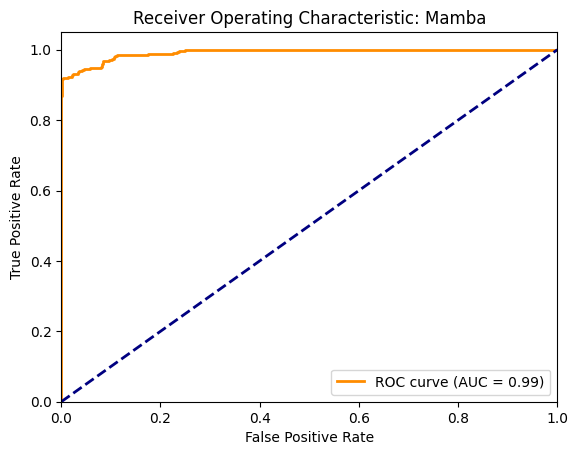

Accuracy: 0.9474
F1 Score: 0.9474
Jaccard Score: 0.8965
Cohen's Kappa Score: 0.8947
Sensitivity: 0.9448
Specificity: 0.9498
AUC: 0.9920
Confusion Matrix:
[[3179  168]
 [ 172 2945]]
McNemar Test: 168.0, p-value: 0.8707870448764395

Holdout Validation with 25% test size:


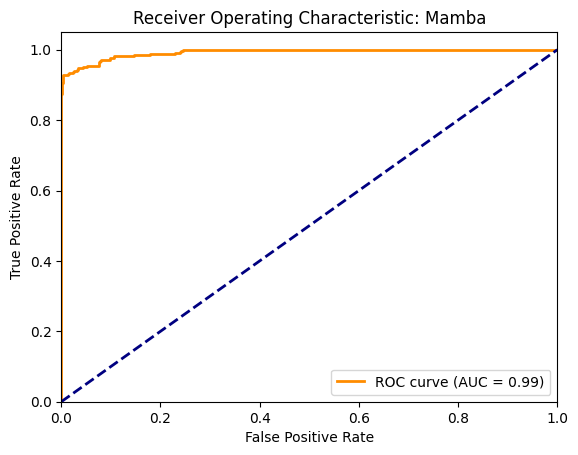

Accuracy: 0.9527
F1 Score: 0.9527
Jaccard Score: 0.9074
Cohen's Kappa Score: 0.9053
Sensitivity: 0.9499
Specificity: 0.9553
AUC: 0.9928
Confusion Matrix:
[[1580   74]
 [  79 1499]]
McNemar Test: 74.0, p-value: 0.7465275303369365

Cross-validation with 5-fold:


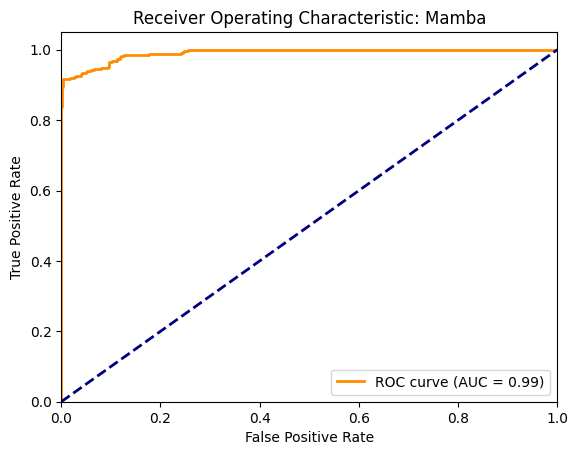

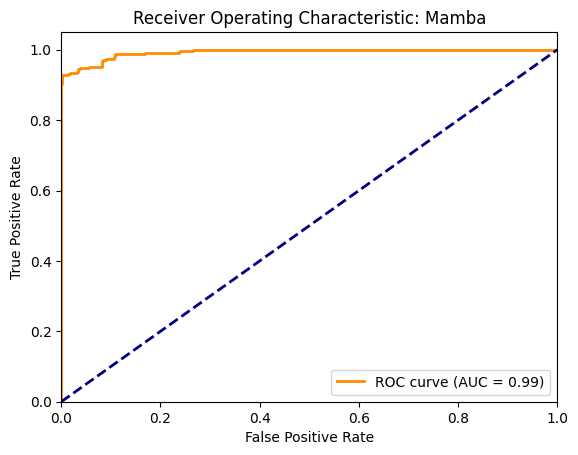

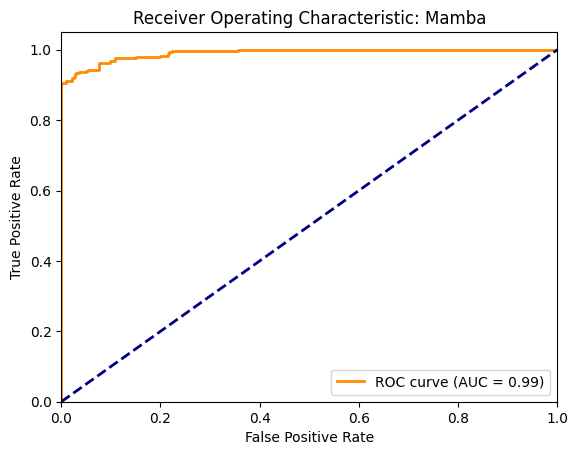

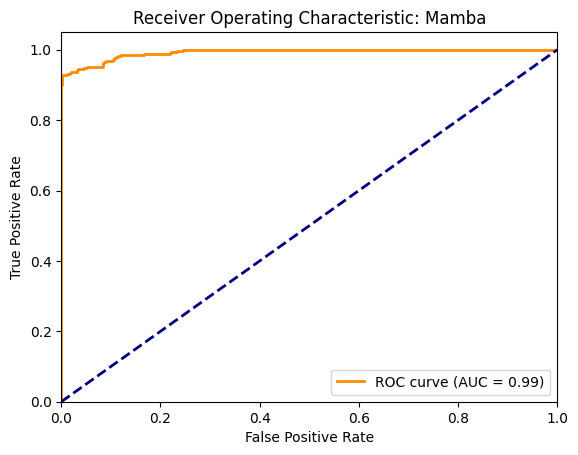

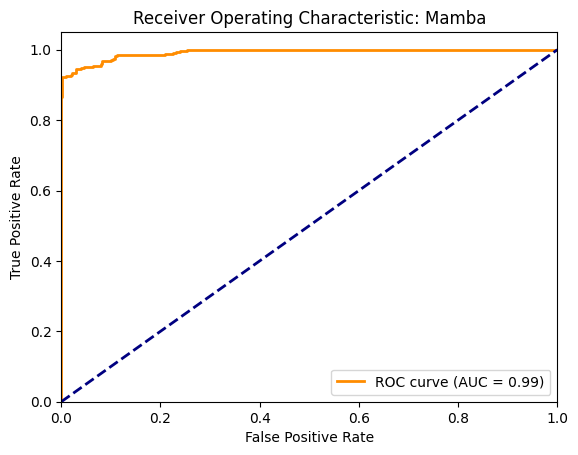

Mean Accuracy: 0.9472
Mean F1 Score: 0.9472
Mean AUC: 0.9918

Cross-validation with 10-fold:


In [ ]:
#mamba
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Decrease feature values for 'H' samples by 50%
X.loc[y == 1] = X.loc[y == 1] * 0.7



# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

# Define Mamba architecture
class MambaClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MambaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, batch_first=True, num_layers=2, dropout=0.3)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        x, _ = self.lstm(x)
        x = self.fc3(x[:, -1, :])
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Instantiate the model
model = MambaClassifier(input_dim=X.shape[1], num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        _, predicted = torch.max(output, 1)
        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
        f1 = f1_score(y_test.numpy(), predicted.numpy(), average='weighted')
        jaccard = jaccard_score(y_test.numpy(), predicted.numpy())
        kappa = cohen_kappa_score(y_test.numpy(), predicted.numpy())
        conf_matrix = confusion_matrix(y_test.numpy(), predicted.numpy())
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcnemar_test = mcnemar(conf_matrix)
        auc_score = roc_auc_score(y_test.numpy(), torch.softmax(output, dim=1)[:, 1].numpy())
        fpr, tpr, _ = roc_curve(y_test.numpy(), torch.softmax(output, dim=1)[:, 1].numpy())

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic: Mamba')
        plt.legend(loc="lower right")
        plt.show()

        return {
            'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa,
            'sensitivity': sensitivity, 'specificity': specificity, 'conf_matrix': conf_matrix,
            'auc_score': auc_score, 'mcnemar': mcnemar_test
        }

# Holdout Validation Function
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=42)
    
    # Convert back to tensors
    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
    
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

    results = evaluate_model(model, X_test, y_test)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")
    print(f"Jaccard Score: {results['jaccard']:.4f}")
    print(f"Cohen's Kappa Score: {results['kappa']:.4f}")
    print(f"Sensitivity: {results['sensitivity']:.4f}")
    print(f"Specificity: {results['specificity']:.4f}")
    print(f"AUC: {results['auc_score']:.4f}")
    print(f"Confusion Matrix:\n{results['conf_matrix']}")
    print(f"McNemar Test: {results['mcnemar'].statistic}, p-value: {results['mcnemar'].pvalue}")

# Cross-Validation Function
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    results = {'accuracy': [], 'f1': [], 'auc': []}
    
    for train_idx, test_idx in skf.split(X.numpy(), y.numpy()):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
            scheduler.step()

        eval_results = evaluate_model(model, X_test, y_test)
        results['accuracy'].append(eval_results['accuracy'])
        results['f1'].append(eval_results['f1'])
        results['auc'].append(eval_results['auc_score'])
    
    print(f"Mean Accuracy: {np.mean(results['accuracy']):.4f}")
    print(f"Mean F1 Score: {np.mean(results['f1']):.4f}")
    print(f"Mean AUC: {np.mean(results['auc']):.4f}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-Validation
cross_validation(5)  # 5-fold cross-validation
cross_validation(10)  # 10-fold cross-validation



In [ ]:
#transformer
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, jaccard_score, roc_auc_score, roc_curve, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)

X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

# Define Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, 256)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Instantiate the model
model = TransformerClassifier(input_dim=X.shape[1], num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        _, predicted = torch.max(test_output, 1)
        y_test_np = y_test.numpy()
        predicted_np = predicted.numpy()
        
        accuracy = accuracy_score(y_test_np, predicted_np)
        f1 = f1_score(y_test_np, predicted_np, average='weighted')
        jaccard = jaccard_score(y_test_np, predicted_np)
        kappa = cohen_kappa_score(y_test_np, predicted_np)
        conf_matrix = confusion_matrix(y_test_np, predicted_np)
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcnemar_test = mcnemar(conf_matrix)
        auc_score = roc_auc_score(y_test_np, test_output.softmax(dim=1)[:, 1].numpy())
        fpr, tpr, _ = roc_curve(y_test_np, test_output.softmax(dim=1)[:, 1].numpy())

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

        return {
            'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa,
            'sensitivity': sensitivity, 'specificity': specificity, 'conf_matrix': conf_matrix,
            'auc_score': auc_score, 'mcnemar': mcnemar_test
        }

# Holdout Validation Function
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=42)
    
    # Convert back to tensors
    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
    
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

    results = evaluate_model(model, X_test, y_test)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")
    print(f"Jaccard Score: {results['jaccard']:.4f}")
    print(f"Cohen's Kappa Score: {results['kappa']:.4f}")
    print(f"Sensitivity: {results['sensitivity']:.4f}")
    print(f"Specificity: {results['specificity']:.4f}")
    print(f"AUC: {results['auc_score']:.4f}")
    print(f"Confusion Matrix:\n{results['conf_matrix']}")
    print(f"McNemar Test: {results['mcnemar'].statistic}, p-value: {results['mcnemar'].pvalue}")

# Cross-Validation Function
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    results = {'accuracy': [], 'f1': [], 'auc': []}
    
    for train_idx, test_idx in skf.split(X.numpy(), y.numpy()):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        eval_results = evaluate_model(model, X_test, y_test)
        results['accuracy'].append(eval_results['accuracy'])
        results['f1'].append(eval_results['f1'])
        results['auc'].append(eval_results['auc_score'])
    
    print(f"Mean Accuracy: {np.mean(results['accuracy']):.4f}")
    print(f"Mean F1 Score: {np.mean(results['f1']):.4f}")
    print(f"Mean AUC: {np.mean(results['auc']):.4f}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-Validation
cross_validation(5)  # 5-fold cross-validation
cross_validation(10)  # 10-fold cross-validation




Holdout Validation with 50% test size:


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



LightGBM Results:
Accuracy: 0.9279084158415841
F1 Score: 0.9247659024862772
Jaccard Score: 0.8600600600600601
Cohen's Kappa Score: 0.8555703735683136
AUC: 0.9780652932217562
Sensitivity: 0.9188322104587745
Specificity: 0.9363609202270691
Confusion Matrix:
[[3134  213]
 [ 253 2864]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.94      0.93      3347
Hypertensive       0.93      0.92      0.92      3117

    accuracy                           0.93      6464
   macro avg       0.93      0.93      0.93      6464
weighted avg       0.93      0.93      0.93      6464



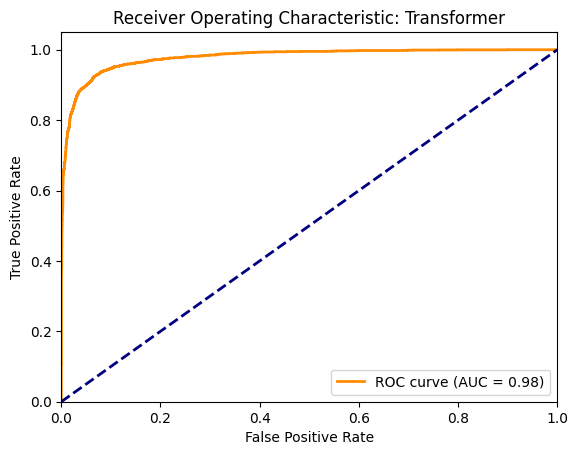


Holdout Validation with 25% test size:


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



LightGBM Results:
Accuracy: 0.9226485148514851
F1 Score: 0.9207355738744453
Jaccard Score: 0.8531139835487661
Cohen's Kappa Score: 0.8452069322772666
AUC: 0.9771351625969535
Sensitivity: 0.9201520912547528
Specificity: 0.9250302297460702
Confusion Matrix:
[[1530  124]
 [ 126 1452]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.93      0.92      1654
Hypertensive       0.92      0.92      0.92      1578

    accuracy                           0.92      3232
   macro avg       0.92      0.92      0.92      3232
weighted avg       0.92      0.92      0.92      3232



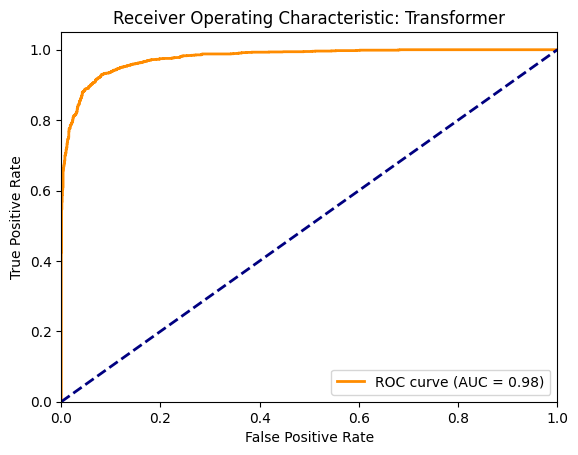


Cross-validation with 5-fold:

LightGBM Cross-validation Results:
Mean Accuracy: 0.9321627989426775
Mean F1 Score: 0.9284676829019224
Mean AUC: 0.9818952883006974

Cross-validation with 10-fold:

LightGBM Cross-validation Results:
Mean Accuracy: 0.9339416338033566
Mean F1 Score: 0.9302069896215162
Mean AUC: 0.982224195973906


In [2]:
#transformer
#lightgbm 
# Required imports
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc, jaccard_score, cohen_kappa_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/kaggle/input/tf-bcg/segmented_data_statistics.csv')
data['Label'] = data['Filename'].apply(lambda x: 1 if 'H' in x else 0)
X = data.drop(columns=['Filename', 'Label'])
y = data['Label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Hypertensive'])
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'jaccard': jaccard, 'kappa': kappa, 'auc': auc_score, 
        'sensitivity': sensitivity, 'specificity': specificity, 'confusion_matrix': conf_matrix, 
        'report': report, 'roc_auc': roc_auc, 'roc_curve': (fpr, tpr)
    }

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: Transformer')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the LightGBM model parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 100
}

# Holdout Validation with 50% and 25% test size
# Holdout Validation with 50% and 25% test size
def holdout_validation(test_size):
    print(f"\nHoldout Validation with {int(test_size*100)}% test size:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    
    # You can control verbosity by using 'verbose' in params
    params['verbose'] = -1  # Set to -1 to suppress output, or 1 for verbose output
    
    # Remove verbose_eval and control verbosity via params
    model = lgb.train(params, lgb_train, valid_sets=[lgb_test], num_boost_round=100)
    
    y_pred_prob = model.predict(X_test)
    y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
    
    results = evaluate_model(y_test, y_pred, y_pred_prob)
    print("\nLightGBM Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"F1 Score: {results['f1']}")
    print(f"Jaccard Score: {results['jaccard']}")
    print(f"Cohen's Kappa Score: {results['kappa']}")
    print(f"AUC: {results['auc']}")
    print(f"Sensitivity: {results['sensitivity']}")
    print(f"Specificity: {results['specificity']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['report']}")
    plot_roc_curve(*results['roc_curve'], results['roc_auc'], "Transformer")





# Cross-validation with 5-fold and 10-fold
def cross_validation(folds):
    print(f"\nCross-validation with {folds}-fold:")
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    model = lgb.LGBMClassifier(**params)
    results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    
    print("\nLightGBM Cross-validation Results:")
    print(f"Mean Accuracy: {results['test_accuracy'].mean()}")
    print(f"Mean F1 Score: {results['test_f1'].mean()}")
    print(f"Mean AUC: {results['test_roc_auc'].mean()}")

# Perform Holdout Validation
holdout_validation(0.5)  # 50% test size
holdout_validation(0.25)  # 25% test size

# Perform Cross-validation
cross_validation(5)  # 5-fold CV
cross_validation(10)  # 10-fold CV
